In [6]:
import sys
import os

utils_path = os.path.abspath(r"C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis")
if utils_path not in sys.path:
    sys.path.append(utils_path)

from utils.utils import *
from utils.Visualizations import *
from ot.datasets import make_1D_gauss as gauss
import cvxpy as cp
import numpy as np
from utils.Classes import TransportResults

In [3]:
def create_constraints(source, target):
    """
    This function takes two lists as input and creates a matrix variable and a set of constraints.

    Parameters:
    - source (list): A list of non-negative numbers representing the source distribution and a 0 at the start.
    - target (list): A list of non-negative numbers representing the target distribution and a 0 at the start.

    Returns:
    - T_matrix (cvxpy.Variable): A matrix variable with shape (len(source), len(target)) representing the transport plan.
    - cons (list): A list of cvxpy constraints.
    """

    n = len(source)
    T_matrix = cp.Variable((n, n), nonneg=True)
    source_sum = sum([abs(el) for el in source])
    target_sum = sum([abs(el) for el in target])
    diff = abs(source_sum - target_sum)

    # Create constraints
    cons = [
        # Sum over j
        *[cp.sum(T_matrix[i,1:]) - T_matrix[i,0] == source[i] for i in range(1, n)],
        # Sum over i
        *[cp.sum(T_matrix[1:,j]) - T_matrix[0,j] == target[j] for j in range(1, n)],
        # Non-negativity constraint
        T_matrix >= 0,
        T_matrix[0,0] == 0
    ]

    return T_matrix, cons

In [4]:
def extend_s_t(s, t):
    """
    This function takes two numpy arrays as input representing the source and target distributions, and returns the extended versions of these distributions.

    Parameters:
    - s (numpy array): A numpy array representing the source distribution.
    - t (numpy array): A numpy array representing the target distribution.

    Returns:
    - s_ext (numpy array): The extended source distribution.
    - t_ext (numpy array): The extended target distribution.
    """

    # Compute s_0 and t_0
    s_0 = max(0, np.sum(t) - np.sum(s))
    t_0 = max(0, np.sum(s) - np.sum(t))

    # Extend s and t
    s_ext = np.concatenate(([s_0], s))
    t_ext = np.concatenate(([t_0], t))

    return s_ext, t_ext

In [56]:
n_p = 20
n_q = 20
p = (gauss(n_p, np.floor(1 * n_p / 4.), 2.) + gauss(n_p, np.floor(2 * n_p / 4.), 2.) * (-0.5)).flatten()
q = (gauss(n_q, np.floor(5 * n_q / 8.), 2.) + gauss(n_q, np.floor(7 * n_q / 8.), 2.) * (-0.5)).flatten()
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

In [47]:
n_p = 2
n_q = 2
p = np.array([0,0])
q = np.array([-1, 1])
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

In [57]:
C = np.zeros([n_p+1, n_q+1], dtype=np.float64)
dist_f2 = lambda a, b : (a-b)**2

C0 = 2000 # cost of mass creation
C1 = 1  # cost of negative mass transportation
C2 = 1  # cost of mass destruction

# Compute cost matrix for original source-target pairs
for it1 in range(n_p):
    C[0,it1+1] = C0
    C[it1+1,0] = C0
    for it2 in range(n_q):
        C[it1+1, it2+1] = dist_f2(X[it1], Y[it2])


In [58]:
def solve_transport_problem(source, target, cost_matrix):
    """
    This function solves the optimal transport problem for given source and target distributions and a cost matrix.

    Parameters:
    - source (list): A list of numbers representing the source distribution.
    - target (list): A list of numbers representing the target distribution.
    - cost_matrix (np.ndarray): A 2D numpy array representing the cost of transporting each unit of mass.

    Returns:
    - TransportResults: A named tuple containing the optimal total transported mass, the optimal transport plan,
                        and the original source and target distributions.
    """
    source_extended, target_extended = extend_s_t(source, target)
    p, constraints = create_constraints(source_extended, target_extended)
    obj = cp.Minimize(cp.sum(cp.multiply(p, cost_matrix)))
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return prob.value, p.value, source.flatten(), target.flatten()

In [59]:
source_extended, target_extended = extend_s_t(p, q)

In [60]:
target_extended.shape

(21,)

In [61]:
prob_value, transport_plan, source, target = solve_transport_problem(p, q, C)

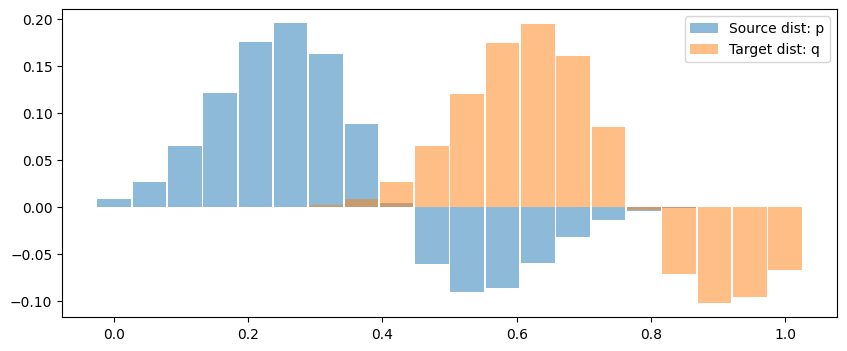

In [62]:
plot_marginals(X, source, target, '')

Text(0.5, 1.0, 'Burrowing')

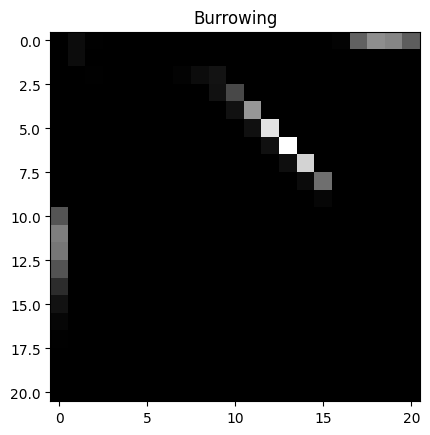

In [63]:
plt.imshow(transport_plan, cmap='gray')
plt.title('Burrowing')

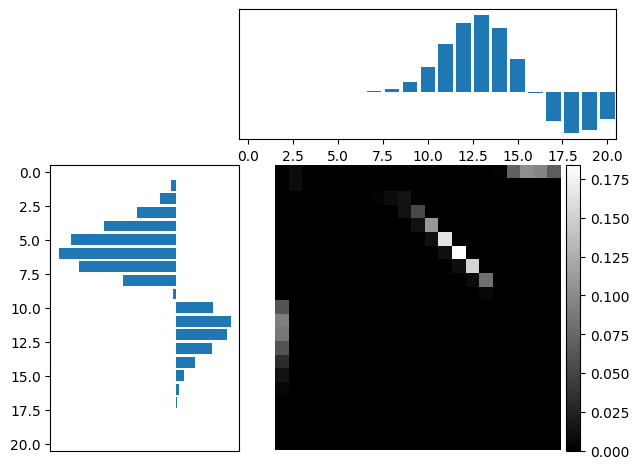

In [34]:
plot_transport_map_with_marginals(source_extended, target_extended, transport_plan, '')

In [35]:
sol, constraints = create_constraints(source_extended, target_extended)

In [36]:
source = p

In [37]:
target = q

In [38]:
n = len(source)
T_matrix = cp.Variable((n, n), nonneg=True)
source_sum = sum([abs(el) for el in source])
target_sum = sum([abs(el) for el in target])
diff = abs(source_sum - target_sum)

In [39]:
cons = [
    # Sum over j
    *[cp.sum(T_matrix[i,1:]) - T_matrix[i,0] == source[i] for i in range(1, n)],
    # Sum over i
    *[cp.sum(T_matrix[1:,j]) - T_matrix[0,j] == target[j] for j in range(1, n)],
    # Non-negativity constraint
    T_matrix >= 0
]

In [40]:
is_source_burrowing = cp.Variable(boolean=True)
is_target_burrowing = cp.Variable(boolean=True)

is_source_burrowing = cp.sum(T_matrix[1:,0]) == 0
is_target_burrowing = cp.sum(T_matrix[0,1:]) == 0

In [41]:
burrowing = cp.ge(1, [is_source_burrowing, is_target_burrowing])

AttributeError: module 'cvxpy' has no attribute 'ge'

In [155]:
burrowing[:]

[Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, ZERO, ()))]

In [156]:
constraint = cp.sum(burrowing[:]) >= 1

TypeError: unsupported operand type(s) for +: 'int' and 'Equality'

In [25]:
obj = cp.Minimize(cp.sum(cp.multiply(p, C)))

ValueError: Cannot broadcast dimensions  (2,) (3, 3)

In [ ]:
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve()

In [ ]:
p.value

In [ ]:
for i in range(1,4):
    print(i)

prob, p_val, source, target = solve_transport_problem(p, q, C)

In [ ]:
p_val

In [ ]:
plt.imshow(C)

In [ ]:
q = [abs(t) for t in q]

In [ ]:
q